# Scraping the issue pages

In [1]:
# anaconda python 3.7.6
from time import sleep
from selenium import webdriver # version 3.141.0
import pandas as pd # version 1.0.1
from bs4 import BeautifulSoup # version 4.8.2
import seaborn as sns # version 0.10.0
import matplotlib.pyplot as plt # version 3.1.3

In [2]:
# make the list of pages to scrape
page_lst = ['https://github.com/uchicago-computation-workshop/Fall2020/issues/1']
# make the list of workshop dates
date_lst = ["2020-10-01"]

In [3]:
def scrape_github_issues(page_lst, date_lst):
    # initialize the webdriver
    driver = webdriver.Chrome()
    driver.maximize_window()
    # intialize an empty dataframe to hold the data
    df = pd.DataFrame()
    # loop thorough pages and scrape
    for idx, url in enumerate(page_lst):
        tmp = scrape_github_issue(url, driver, date_lst[idx])
        df = df.append(tmp)
    driver.close()
    return df

def scrape_github_issue(url, driver, date):
    # load the url and click on the "load more" button to get the full list of comments
    driver.get(url)
    driver.find_element_by_class_name('ajax-pagination-btn').click()
    # wait for the page to load: kind of hacky but also prevents DDOS attacking GitHub
    sleep(4)
    # use beautifulsoup to get the html
    soup = BeautifulSoup(driver.page_source)
    # parse the fist element because it is the preceptor
    all_comments = soup.find_all("div", class_="ml-n3 timeline-comment unminimized-comment comment previewable-edit js-task-list-container js-comment timeline-comment--caret")[1:]
    # create a list of dictionaries holding the scraped stuff
    lst = make_lst(all_comments, date)
    return pd.DataFrame(lst)

def make_lst(all_comments, date):
    # initialize empty list
    lst = []
    # loop through results from find_all and extract the data, put it in a dictionary and append to the list
    for idx, comment in enumerate(all_comments):
        dict = {}
        dict["name"] = comment.find("a", class_="author link-gray-dark css-truncate-target width-fit").text
        dict["time"] = comment.find("a", class_="link-gray js-timestamp").find("relative-time")["datetime"]
        dict["workshop_date"] = date
        dict["position"] = idx
        dict["text"] = comment.find("td", "d-block comment-body markdown-body js-comment-body").text.replace("\n", " ").strip()
        temp_upvote = comment.find("div", class_="comment-reactions-options")
        # if the comment got no upvote such element would not exist
        if temp_upvote is None:
            dict["num_upvotes"] = 0
        else:
            dict["num_upvotes"] = int(temp_upvote.text.split()[1])
        lst.append(dict)
    return lst

def get_time_to_deadline(row):
    # because of the summer time which I still do not understand I need a separate function for this
    # ended at November 3rd
    if row['workshop_date'] in ["2019-10-10", "2019-10-17", "2019-10-24", "2019-10-31", "2020-04-09",
                               "2020-04-30", "2020-05-07", "2020-05-14", "2020-05-21", "2020-05-28", "2020-10-01"]:
        return pd.to_datetime(row['time']) - pd.to_datetime(row['workshop_date'] + '-06', utc=True)
    else:
        return pd.to_datetime(row['time']) - pd.to_datetime(row['workshop_date'] + '-05', utc=True)

In [4]:
df = scrape_github_issues(page_lst, date_lst)
df['time_to_deadline'] = df.apply(get_time_to_deadline, axis=1).astype('timedelta64[m]')
df = df[df['time_to_deadline'] <= 0].copy()
df.to_pickle('scraped_data_1001.pkl')

Text(0.0, 1.0, 'Primacy Effect 2020/10/01 Scraped at 10:22 AM Central')

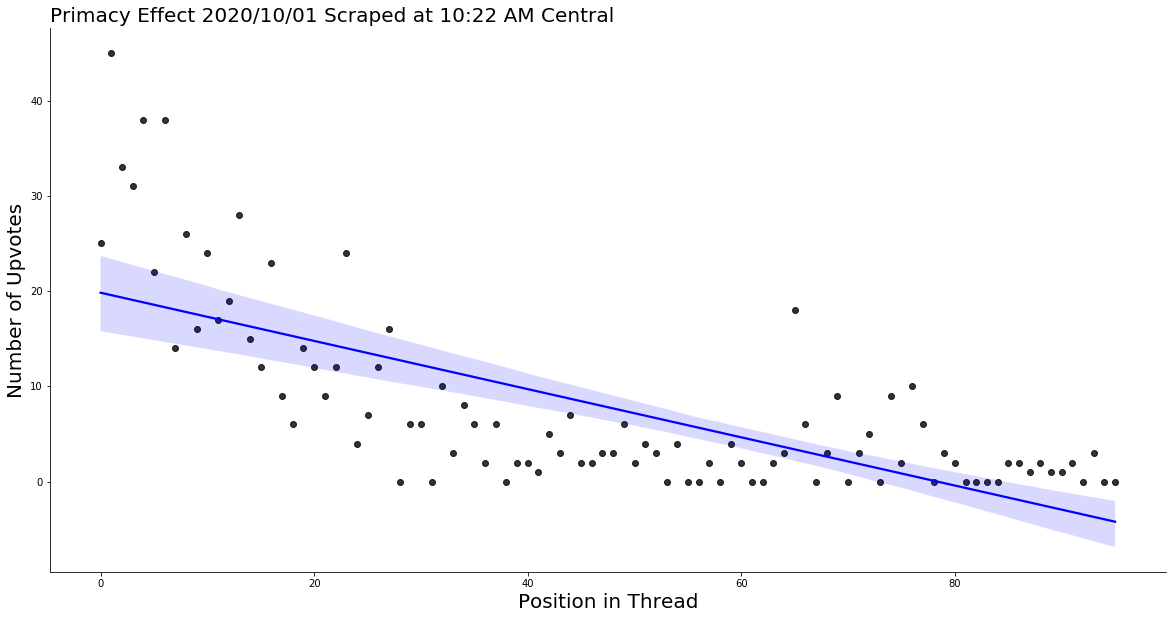

In [5]:
fig, ax = plt.subplots(figsize=(20,10))
sns.regplot(data=df, x='position', y='num_upvotes', ax=ax, color="black", line_kws={'color':'blue'})
sns.despine()
ax.set_xlabel('Position in Thread', size=20)
ax.set_ylabel('Number of Upvotes', size=20)
ax.set_title('Primacy Effect 2020/10/01 Scraped at 10:22 AM Central', size=20, loc='left')